#### Librairies et lecture des jeux de données

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import argparse
from torch.serialization import save
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt

from kmembert.models import HealthBERT
from kmembert.utils import create_session

In [2]:
# Import argparse
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("-d", "--data_folder", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-p", "--path_dataset", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-r", "--resume", type=str, default="kmembert-base", 
    help="result folder in with the saved checkpoint will be reused")
parser.add_argument("-nr", "--nrows", type=int, default=10, 
    help="maximum number of samples for testing")
parser.add_argument("-f", "--folder_to_save", type=str, default="graphs", 
    help="folder to save the figures")
parser.add_argument("-ng", "--noigr", type=int, default=2, 
    help="The Noigr of a patient")
args = parser.parse_args("")

In [3]:
# Read df used to test
# Creation du jeu de donnees pour retrouver les infos interessantes
test = pd.read_csv("kmembert\\Visualization\\test_VM.csv")

# Read df with prediction
res_pred = pd.read_csv("kmembert\\Visualization\\results_pred_VM.csv")

# Merge 2 dataframes
resul_df = pd.merge(test, res_pred, left_on="indice", right_on="ind")[['Noigr', 'Date cr', 'Date deces', 'Texte', 'indice', 'pred', 'lab']]

# Add columns to have absolute error between pred and lab
resul_df['ecart'] = abs(resul_df['pred']-resul_df['lab'])

resul_df['nb_words'] = resul_df['Texte'].apply(lambda x: len(x.split()))

resul_df['nb_docs'] = resul_df.groupby(["Noigr"])["Noigr"].transform("count")

resul_df = resul_df.sort_values("ecart", ascending=False)

#### Modification du jeu de données

In [13]:
# Add Karnofsky_FLAG_0... to show which PS it is
resul_df['K_flag_1'] = resul_df['Texte'].apply(lambda x: "Karnofsky = 10 %" in x)
resul_df['K_flag_2'] = resul_df['Texte'].apply(lambda x: "Karnofsky = 20 %" in x)
resul_df['K_flag_3'] = resul_df['Texte'].apply(lambda x: "Karnofsky = 30 %" in x)
resul_df['K_flag_4'] = resul_df['Texte'].apply(lambda x: "Karnofsky = 40 %" in x)
resul_df['K_flag_5'] = resul_df['Texte'].apply(lambda x: "Karnofsky = 50 %" in x)
resul_df['K_flag_6'] = resul_df['Texte'].apply(lambda x: "Karnofsky = 60 %" in x)
resul_df['K_flag_7'] = resul_df['Texte'].apply(lambda x: "Karnofsky = 70 %" in x)
resul_df['K_flag_8'] = resul_df['Texte'].apply(lambda x: "Karnofsky = 80 %" in x)
resul_df['K_flag_9'] = resul_df['Texte'].apply(lambda x: "Karnofsky = 90 %" in x)
resul_df['K_flag_10'] = resul_df['Texte'].apply(lambda x: "Karnofsky = 100 %" in x)

# Add Karnofsky_flag to show which Karnofsky it is
# create a list of our conditions
conditions = [
    (resul_df['K_flag_1'] == True) | (resul_df['K_flag_2'] == True),
    (resul_df['K_flag_3'] == True) | (resul_df['K_flag_4'] == True),
    (resul_df['K_flag_5'] == True) | (resul_df['K_flag_6'] == True),
    (resul_df['K_flag_7'] == True) | (resul_df['K_flag_8'] == True),
    (resul_df['K_flag_9'] == True) | (resul_df['K_flag_10'] == True)]

# create a list of the values we want to assign for each condition
values = ["Karnofsky < 20 %", "Karnofsky < 40 %", "Karnofsky < 60 %", "Karnofsky < 80 %", "Karnofsky < 100 %"]

resul_df['Kar_FLAG'] = np.select(conditions, values)
resul_df_Kar = resul_df[resul_df.Kar_FLAG != '0']

# Number of occurences per type
resul_df_Kar['Kar_count'] = resul_df_Kar.groupby(["Kar_FLAG"])["Kar_FLAG"].transform("count")

resul_df_Kar = resul_df_Kar.drop(['K_flag_1', 'K_flag_2', 'K_flag_3', 'K_flag_4', 'K_flag_5', 
                    'K_flag_6', 'K_flag_7', 'K_flag_8', 'K_flag_9', 'K_flag_10'], axis = 1)

resul_df_Kar.head(2)

c:\Users\DIPIAZZA\Anaconda3\envs\clb_env2\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Noigr,Date cr,Date deces,Texte,indice,pred,lab,ecart,nb_words,nb_docs,Kar_FLAG,Kar_count
4578,4443257,20141230,20150122,"Karnofsky = 40 %, PS = 3. Présents : Oncologu...",4578,0.122051,0.983489,0.861438,95,66,Karnofsky < 40 %,215
24272,2828445,20120105,20180131,"Karnofsky = 30 %, PS = 4, Poids actuel = 65,0 ...",24272,0.110985,0.940170,0.829185,192,32,Karnofsky < 40 %,215


#### Test statistique : Kruskal

In [14]:
# Test Statistique sur les différences de temps de survie des patients : Valeures observees
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

a = resul_df_Kar[resul_df_Kar.Kar_FLAG=="Karnofsky < 20 %"]['lab']
b = resul_df_Kar[resul_df_Kar.Kar_FLAG=="Karnofsky < 40 %"]['lab']
c = resul_df_Kar[resul_df_Kar.Kar_FLAG=="Karnofsky < 60 %"]['lab']
d = resul_df_Kar[resul_df_Kar.Kar_FLAG=="Karnofsky < 80 %"]['lab']
e = resul_df_Kar[resul_df_Kar.Kar_FLAG=="Karnofsky < 100 %"]['lab']
print("Kruskal, pvalue: ", stats.kruskal(a, b, c, d, e))
print("Anova, pvalue: ", stats.f_oneway(a, b, c, e, e))

Kruskal, pvalue:  KruskalResult(statistic=632.7534594247377, pvalue=1.26155783201403e-135)
Anova, pvalue:  F_onewayResult(statistic=176.9766471737094, pvalue=2.6379870611951666e-146)


In [15]:
# Test Statistique sur les différences de temps de survie des patients : Valeures observees
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

a = resul_df_Kar[resul_df_Kar.Kar_FLAG=="Karnofsky < 20 %"]['pred']
b = resul_df_Kar[resul_df_Kar.Kar_FLAG=="Karnofsky < 40 %"]['pred']
c = resul_df_Kar[resul_df_Kar.Kar_FLAG=="Karnofsky < 60 %"]['pred']
d = resul_df_Kar[resul_df_Kar.Kar_FLAG=="Karnofsky < 80 %"]['pred']
e = resul_df_Kar[resul_df_Kar.Kar_FLAG=="Karnofsky < 100 %"]['pred']
print("Kruskal, pvalue: ", stats.kruskal(a, b, c, d, e))
print("Anova, pvalue: ", stats.f_oneway(a, b, c, e, e))

Kruskal, pvalue:  KruskalResult(statistic=1187.4849097317278, pvalue=8.227295974113137e-256)
Anova, pvalue:  F_onewayResult(statistic=352.2408738980537, pvalue=1.2601926432768608e-282)


#### BoxPlot

Text(0.5, 1.0, 'BoxPlot - Survival label per Karnofsky Value')

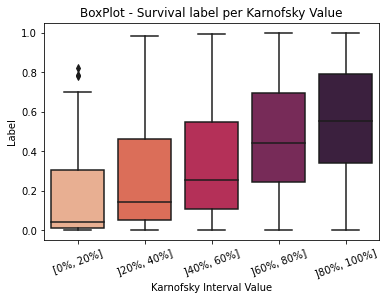

In [26]:
# BoxPlot - Survival Time per Kernofsky - Observed Values
fig = plt.figure()
ax = plt.subplot(111)

sns.boxplot(x='Kar_FLAG', y='lab', data=resul_df_Kar, 
        order=["Karnofsky < 20 %", "Karnofsky < 40 %", "Karnofsky < 60 %", "Karnofsky < 80 %", "Karnofsky < 100 %"], 
        palette='rocket_r')
plt.xlabel("Karnofsky Interval Value")
plt.xticks(rotation=20)
ax.set_xticklabels(["[0%, 20%]", "]20%, 40%]", "]40%, 60%]", "]60%, 80%]", "]80%, 100%]"])
plt.ylabel("Label")
plt.title("BoxPlot - Survival label per Karnofsky Value")

Text(0.5, 1.0, 'BoxPlot - Survival label per Karnofsky Value')

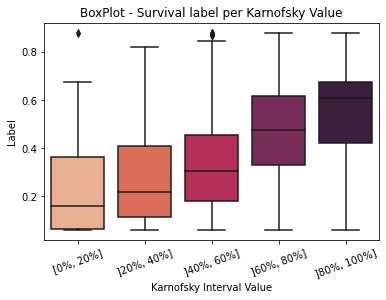

In [27]:
# BoxPlot - Survival Time per Kernofsky - Predicted Values
fig = plt.figure()
ax = plt.subplot(111)

sns.boxplot(x='Kar_FLAG', y='pred', data=resul_df_Kar, 
        order=["Karnofsky < 20 %", "Karnofsky < 40 %", "Karnofsky < 60 %", "Karnofsky < 80 %", "Karnofsky < 100 %"], 
        palette='rocket_r')
plt.xlabel("Karnofsky Interval Value")
plt.xticks(rotation=20)
ax.set_xticklabels(["[0%, 20%]", "]20%, 40%]", "]40%, 60%]", "]60%, 80%]", "]80%, 100%]"])
plt.ylabel("Label")
plt.title("BoxPlot - Survival label per Karnofsky Value")

Text(3.925, -0.22, '4067')

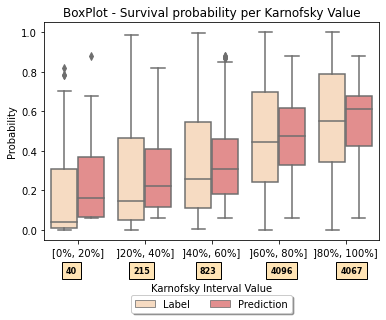

In [40]:
# BoxPlot - Survival Time per PS - Prediction and Observed Label
fig = plt.figure()
ax = plt.subplot(111)

# Ajustement du jeu de données
df_plot = resul_df_Kar.melt(id_vars='Kar_FLAG', value_vars=["lab", "pred"])
df_plot['variable'] = df_plot['variable'].replace('lab', 'Label')
df_plot['variable'] = df_plot['variable'].replace('pred', 'Prediction')

# Plot
sns.boxplot(x='Kar_FLAG', y='value', hue='variable', data=df_plot, 
            order=["Karnofsky < 20 %", "Karnofsky < 40 %", "Karnofsky < 60 %", "Karnofsky < 80 %", "Karnofsky < 100 %"], 
            palette=['peachpuff', 'lightcoral'])#'rocket_r')
plt.xlabel("Karnofsky Interval Value")
plt.ylabel("Probability")
plt.title("BoxPlot - Survival probability per Karnofsky Value")

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.23),
          fancybox=True, shadow=True, ncol=5)
ax.set_xticklabels(["[0%, 20%]", "]20%, 40%]", "]40%, 60%]", "]60%, 80%]", "]80%, 100%]"])
ax.xaxis.set_label_coords(0.5, -0.2)
# Plot text
plt.text(-0.175, -0.22, '40', fontsize = 10, fontweight='bold', size=8, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.175+1, -0.22, '215', fontsize = 10, fontweight='bold', size=8, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.175+2, -0.22, '823', fontsize = 10, fontweight='bold', size=8, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.175+3.05, -0.22, '4096', fontsize = 10, fontweight='bold', size=8, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.175+4.1, -0.22, '4067', fontsize = 10, fontweight='bold', size=8, color='black', bbox=dict(facecolor='moccasin'))